In [1]:
import os
import sys
import pickle
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from uuid import UUID
from collections import defaultdict

%matplotlib inline

In [2]:
emission_path = Path(os.getcwd()).parent.parent / 'my_emission_server' / 'e-mission-server'
sys.path.append(str(emission_path))

# Also add the home (viz_scripts) to the path
sys.path.append('../viz_scripts')

In [3]:
import scaffolding
import emission.core.get_database as edb

storage not configured, falling back to sample, default configuration
URL not formatted, defaulting to "Stage_database"
Connecting to database URL localhost


In [4]:
importlib.reload(scaffolding)

<module 'scaffolding' from '/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py'>

In [5]:
def r(df: pd.DataFrame) -> pd.DataFrame:
    return df.reset_index(drop=True, inplace=False)

In [6]:
with open('../viz_scripts/auxiliary_files/dic_re.pkl', 'rb') as f:
    dic_re = pickle.loads(f.read())

with open('../viz_scripts/auxiliary_files/dic_pur.pkl', 'rb') as f:
    dic_pur = pickle.loads(f.read())

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other', dic_re)
dic_pur = defaultdict(lambda: 'Other', dic_pur)

In [7]:
# Split UUIDs by program
program_uuid_map = {}
for ue in edb.get_uuid_db().find():
    uuid = str(ue['uuid'])
    # uuid = str(ue['uuid'])
    program = ue['user_email'].split("_")[0]
    if program in program_uuid_map.keys():
        program_uuid_map[program].append(uuid)
    else:
        print(f"Found new program {program}, creating new list")
        program_uuid_map[program] = []
        program_uuid_map[program].append(uuid)

uuid_program_list = []
for ue in edb.get_uuid_db().find():
    # uuid = str(ue['uuid'].as_uuid(3))
    uuid = str(ue['uuid'])
    program = ue['user_email'].split("_")[0]
    uuid_program_list.append({"program": program, "opcode": ue["user_email"], "user_id": uuid})

Found new program stage, creating new list
Found new program 4c, creating new list
Found new program cc, creating new list
Found new program fc, creating new list
Found new program pc, creating new list
Found new program sc, creating new list
Found new program vail, creating new list
Found new program prepilot, creating new list


In [8]:
uuid_program_df = pd.DataFrame(uuid_program_list)

In [9]:
# %%capture

# for program in uuid_program_df.program.unique():
expanded_ct, file_suffix, quality_text, debug_df = scaffolding.load_viz_notebook_data(None,
                                                                            None,
                                                                            'prepilot',
                                                                            'program',
                                                                            dic_re,
                                                                            dic_pur=dic_pur)

Loaded all confirmed trips of length 241123
After filtering, found 241123 participant trips 
After filtering, found 92446 labeled trips
Found Index(['mode_confirm', 'purpose_confirm', 'replaced_mode'], dtype='object') columns of length 3
After expanding, columns went from 41 -> 44
_prepilot
Based on 92395 confirmed trips from 235 users
of 241123 total  trips from 261 users (38.32%)


In [10]:
# Join to the program df to get each user's program
expanded_ct['original_user_id'] = expanded_ct['user_id'].copy()
expanded_ct['user_id'] = expanded_ct['user_id'].apply(lambda x: str(x))
expanded_ct = expanded_ct.merge(uuid_program_df, on='user_id')
expanded_ct['user_id'] = expanded_ct['user_id'].apply(lambda x: str(x).replace("-", ""))

In [11]:
expanded_ct.columns

Index(['source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts',
       'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place',
       'end_place', 'cleaned_trip', 'inferred_labels', 'inferred_trip',
       'expectation', 'confidence_threshold', 'expected_trip', 'user_input',
       'section_modes', 'section_distances', 'start_local_dt_year',
       'start_local_dt_month', 'start_local_dt_day', 'start_local_dt_hour',
       'start_local_dt_minute', 'start_local_dt_second',
       'start_local_dt_weekday', 'start_local_dt_timezone',
       'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
       'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
       'end_local_dt_weekday', 'end_local_dt_timezone', '_id', 'user_id',
       'metadata_write_ts', 'additions', 'mode_confirm', 'purpose_confirm',
       'replaced_mode', 'distance_miles', 'Mode_confirm', 'Replaced_mode',
       'Trip_purpose', 'original_user_id', 'program', 'opcode'],
 

In [12]:
# Rename the target column.
expanded_ct.drop(columns=['replaced_mode'], axis='rows', inplace=True)
expanded_ct['Replaced_mode'] = expanded_ct['Replaced_mode'].fillna('Unlabeled')

In [13]:
len(expanded_ct.user_id.unique())

235

## Survey Data preprocessing

In [14]:
# Read the Denver dedmographic info
survey_data = pd.read_csv('../viz_scripts/Can Do Colorado eBike Program - en.csv')

In [15]:
survey_data.rename(
    {
        "Unique User ID (auto-filled, do not edit)": "user_id",
        "In which year were you born?": "birth_year",
        "What is your gender?": "gender",
        "Do you have a valid driver's license?": "has_drivers_license",
        "Are you a student?": "is_student",
        "What is the highest grade or degree that you have completed?": "highest_education",
        "Do you work for either pay or profit?": "is_paid",
        "Do you have more than one job?": "has_multiple_jobs",
        "Do you work full-time or part-time at your primary job?": "primary_job_type",
        "Which best describes your primary job?": "primary_job_description",
        "How did you usually get to your primary job last week? ": "primary_job_commute_mode",
        "Thinking about your daily commute to work last week, how many minutes did it usually take to get from home to the primary job/work place?": "primary_job_commute_time",
        "At your primary job, do you have the ability to set or change your own start time?": "is_primary_job_flexible",
        "Do you have the option of working from home or an alternate location instead of going into your primary work place?": "primary_job_can_wfh",
        "How many days per week do you usually work from home or an alternate location?": "wfh_days",
        "Do you own or rent your place of residence?": "residence_ownership_type",
        "What is your home type?": "residence_type",
        "Please identify which category represents your total household income, before taxes, for last year.": "income_category",
        "Including yourself, how many people live in your home?": "n_residence_members",
        "How many children under age 18 live in your home?": "n_residents_u18",
        "Including yourself, how many people have a driver's license in your household?": "n_residents_with_license",
        "How many motor vehicles are owned, leased, or available for regular use by the people who currently live in your household?": "n_motor_vehicles",
        "If you were unable to use your household vehicle(s), which of the following options would be available to you to get you from place to place?": "available_modes",
        "Do you have a medical condition that makes it difficult to travel outside of the home?": "has_medical_condition",
        "How long have you had this condition?": "medical_condition_duration"
    },
    axis='columns',
    inplace=True
)

In [16]:
survey_data['Timestamp'] = pd.to_datetime(survey_data['Timestamp'])
survey_data['Timestamp'] = survey_data['Timestamp'].dt.tz_localize('America/Los_Angeles', ambiguous='infer')
survey_data['Timestamp'] = survey_data['Timestamp'].dt.tz_convert('America/Denver')

/Users/rkulhall/miniconda3/envs/emission/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Users/rkulhall/miniconda3/envs/emission/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [17]:
survey_data.Timestamp.min(), survey_data.Timestamp.max()

(Timestamp('2021-05-23 16:21:52-0600', tz='America/Denver'),
 Timestamp('2022-12-21 06:33:59-0700', tz='America/Denver'))

In [18]:
f_survey = survey_data.loc[survey_data.user_id.isin(expanded_ct.user_id), :]

In [19]:
len(f_survey.user_id.unique()), len(survey_data.user_id.unique())

(170, 203)

In [20]:
f_survey = f_survey.sort_values(
    by=['user_id', 'Timestamp'], ascending=True
).drop_duplicates(
    subset=['user_id'], keep='last', ignore_index=True
)

In [21]:
assert f_survey.user_id.value_counts().max() == 1

In [22]:
# Remove outliers.

bad_ix = list()

# obvious. WFH is not a good feature to include because of its high sparsity.
# wfh_mask = f_survey.wfh_days > 7

# Computed by calculating 99th percentile.
commute_time_mask = f_survey.primary_job_commute_time > 75

# Computed by calculating 99th percentile.
residence_members_mask = f_survey.n_residence_members > 8

for mask in [commute_time_mask, residence_members_mask]:
    bad_ix += f_survey[mask].index.tolist()

f_survey.drop(index=set(bad_ix), inplace=True)

In [23]:
# Find age at the time of the timestamp. subtract birth year from timestamp year.
def compute_age(row):
    if row['birth_year'] < 100:
        return row['birth_year']
    return row['Timestamp'].year - row['birth_year']

f_survey['age'] = f_survey.apply(lambda x: compute_age(x), axis=1)
# f_survey.drop(columns=['birth_year'], inplace=True)


# For those who leave it NA, categorize them as 'prefer not to say'.
f_survey.loc[f_survey['has_multiple_jobs'].isna(), 'has_multiple_jobs'] = 'Prefer not to say'


# Fix primary commute mode.
f_survey.loc[
    f_survey.primary_job_commute_mode.isna(), 'primary_job_commute_mode'
] = 'Unknown'

f_survey.loc[
    f_survey.primary_job_commute_mode.isin([
        'Car', 'SUV', 'Pickup truck', 'Taxi/Limo (including services like Uber or Lyft)', 'Van',
        'Shared vehicle'
    ]), 'primary_job_commute_mode'
] = 'Car transport'

f_survey.loc[
    f_survey.primary_job_commute_mode.isin([
        'Public or commuter bus', 'Buss'
    ]), 'primary_job_commute_mode'
] = 'Public transport'

f_survey.loc[
    f_survey.primary_job_commute_mode.isin([
        'Walk', 'Skateboard', 'Bicycle'
    ]), 'primary_job_commute_mode'
] = 'Active transport'

f_survey.loc[
    f_survey.primary_job_commute_mode.isin([
        'Telecommute', 'Work from home', 'I work from home'
    ]), 'primary_job_commute_mode'
] = 'WFH'

f_survey.loc[
    f_survey.primary_job_commute_mode.isin([
        'Walk, bike, bus, uber or lyft.', 'Car and E-Bike'
    ]), 'primary_job_commute_mode'
] = 'Hybrid'

# Fix primary job type
f_survey.loc[f_survey.primary_job_type.isna(), 'primary_job_type'] = 'Prefer not to say'

# Normalize the job description. Inspired from the 'e-bike trips by occupation' graph.
f_survey.loc[
    f_survey.primary_job_description.isin([
        'Paraprofessional ', 'Education ', 'education/early childhood', 'Teacher',
        'Education non-profit manager', 'Scientific research'
    ]), 'primary_job_description', 
] = 'Education'

f_survey.loc[
    f_survey.primary_job_description.isin([
        'Custodian', 'Custodial ', 'Csu custodian ', 'Janitorial '
    ]), 'primary_job_description'
] = 'Custodial'

f_survey.loc[
    f_survey.primary_job_description.isin([
        'Inbound cs', 'Accounting Technician ', 
    ]), 'primary_job_description'
] = 'Clerical'

f_survey.loc[
    f_survey.primary_job_description.isin([
        'Restaurant manager', 'Transportaion Services',
    ]), 'primary_job_description'
] = 'Sales or service'

f_survey.loc[
    f_survey.primary_job_description.isin([
        'Pastry chef and line cook', 'Cook', 'Chef', 'Dining Services',
        'Food Service', 'Cooking ', 'Residential Dining Services'
    ]), 'primary_job_description'
] = 'Food service'

f_survey.loc[
    f_survey.primary_job_description.isin([
        'CNA', 'Caregiver/ Qmap', 'Health care', 'Nurse',
        'Healthcare', 'Medical', 'Medical field',
        'Family support '
    ]), 'primary_job_description'
] = 'Medical/healthcare'

f_survey.loc[
    f_survey.primary_job_description.isin([
        'Amazon ', 'Hockey rink ', 'Caregiver', 'Security', 'Nonprofit social work '
    ]), 'primary_job_description'
] = 'Other'

f_survey.loc[
    f_survey.primary_job_description.isin([
        'Hospital laundry', 'Maintenance ', 'Matreal handler',
        'Co op laundry'
    ]), 'primary_job_description'
] = 'Manufacturing, construction, maintenance, or farming'

f_survey.loc[f_survey.primary_job_description.isna(), 'primary_job_description'] = 'Other'

In [24]:
# Impute the commute time by grouping by occupation type and using median.
job_commutes = f_survey.groupby('primary_job_description')['primary_job_commute_time'].median()

In [25]:
for job_type in job_commutes.index:
    f_survey.loc[
        (f_survey.primary_job_description == job_type)&(f_survey.primary_job_commute_time.isna()), 
        'primary_job_commute_time'
    ] = job_commutes[job_type]

In [26]:
# Fix motor vehicles. Keep this ordinal.
f_survey.loc[f_survey.n_motor_vehicles == '4+', 'n_motor_vehicles'] = 4
f_survey.loc[f_survey.n_motor_vehicles == 'Prefer not to say / Prefiero no decir.', 'n_motor_vehicles'] = 0
f_survey.n_motor_vehicles = f_survey.n_motor_vehicles.astype(int)

In [27]:
to_drop = [
    'Which one below describe you best?', 'wfh_days', 'primary_job_can_wfh', 'is_primary_job_flexible',
    'medical_condition_duration', 'has_medical_condition', 'residence_type', 'residence_ownership_type',
    'is_paid', 'is_student'
]

f_survey.drop(columns=to_drop, inplace=True)

In [28]:
display(f_survey.isna().sum())

Timestamp                   0
user_id                     0
birth_year                  0
gender                      0
has_drivers_license         0
highest_education           0
has_multiple_jobs           0
primary_job_type            0
primary_job_description     0
primary_job_commute_mode    0
primary_job_commute_time    0
income_category             0
n_residence_members         0
n_residents_u18             0
n_residents_with_license    0
n_motor_vehicles            0
available_modes             0
age                         0
dtype: int64

In [29]:
'''
Let us think about this. Given that the income category is not defined, it does not make sense
to encode the factor as a non-zero ordinal number. 9.6% of the people in the dataset choose to
not disclose their income. We could just drop them, but then we risk losing quite a lot of information.
'''

f_survey.loc[f_survey.income_category == 'Prefer not to say', 'income_category'] = 0
f_survey.loc[f_survey.income_category == 'Less than $24,999', 'income_category'] = 1
f_survey.loc[f_survey.income_category == '$25,000-$49,999', 'income_category'] = 2
f_survey.loc[f_survey.income_category == '$50,000-$99,999', 'income_category'] = 3
f_survey.loc[f_survey.income_category == '$100,000 -$149,999', 'income_category'] = 4
f_survey.loc[f_survey.income_category == '$150,000-$199,999', 'income_category'] = 5
f_survey.loc[f_survey.income_category == '$150,000', 'income_category'] = 5
f_survey.loc[f_survey.income_category == '$150,000-$199,999', 'income_category'] = 6
f_survey.loc[f_survey.income_category == '$200,000 or more', 'income_category'] = 7
f_survey.income_category = f_survey.income_category.astype(int)

# TODO: Think of a strategy here.

In [30]:
f_survey.primary_job_description.value_counts()

Sales or service                                        47
Professional, managerial, or technical                  37
Manufacturing, construction, maintenance, or farming    17
Clerical or administrative support                      17
Other                                                   13
Education                                                9
Food service                                             8
Medical/healthcare                                       8
Custodial                                                7
Clerical                                                 2
Maintenance                                              1
Name: primary_job_description, dtype: int64

In [31]:
display(f_survey.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 169
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype                         
---  ------                    --------------  -----                         
 0   Timestamp                 166 non-null    datetime64[ns, America/Denver]
 1   user_id                   166 non-null    object                        
 2   birth_year                166 non-null    int64                         
 3   gender                    166 non-null    object                        
 4   has_drivers_license       166 non-null    object                        
 5   highest_education         166 non-null    object                        
 6   has_multiple_jobs         166 non-null    object                        
 7   primary_job_type          166 non-null    object                        
 8   primary_job_description   166 non-null    object                        
 9   primary_job_commute_mode  166 no

None

In [32]:
from sklearn.preprocessing import OneHotEncoder

def generate_ohe_features(df, feature_name):
    ohe = OneHotEncoder()
    ohe.fit(df[[feature_name]])
    return pd.DataFrame(
        ohe.transform(df[[feature_name]]).todense(), 
        columns=ohe.get_feature_names_out(),
        index=df.index
    ), ohe

In [33]:
ohe_features = [
    'gender', 'has_drivers_license', 'has_multiple_jobs', 'highest_education', 
    'primary_job_type', 'primary_job_description', 'primary_job_commute_mode'
]

for feature in ohe_features:
    df, _ = generate_ohe_features(f_survey, feature)
    f_survey = f_survey.merge(right=df, left_index=True, right_index=True)

f_survey.drop(columns=ohe_features, inplace=True)

In [34]:
display(f_survey.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 169
Data columns (total 49 columns):
 #   Column                                                                        Non-Null Count  Dtype                         
---  ------                                                                        --------------  -----                         
 0   Timestamp                                                                     166 non-null    datetime64[ns, America/Denver]
 1   user_id                                                                       166 non-null    object                        
 2   birth_year                                                                    166 non-null    int64                         
 3   primary_job_commute_time                                                      166 non-null    float64                       
 4   income_category                                                               166 non-null    int64           

None

In [35]:
from typing import List

def plot_survey_distribution(df: pd.DataFrame, feature_names: List[str]):
    
    n = len(feature_names)
    
    # No more than 4 plots in on subplot.
    assert n <= 4, "Only 4 features can be visualized at a time."
    
    ncols = 2
    nrows = n//ncols if n%ncols == 0 else (n//ncols) + 1
    
    h_scale = 4*nrows
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, h_scale))
    for ix, ax in enumerate(axes.flatten()):
        if ix < n:
            sns.histplot(data=df, y=feature_names[ix], ax=ax)
        else:
            ax.set_axis_off()
    plt.tight_layout()
    plt.show()

ValueError: Could not interpret value `primary_job_commute_mode` for parameter `y`

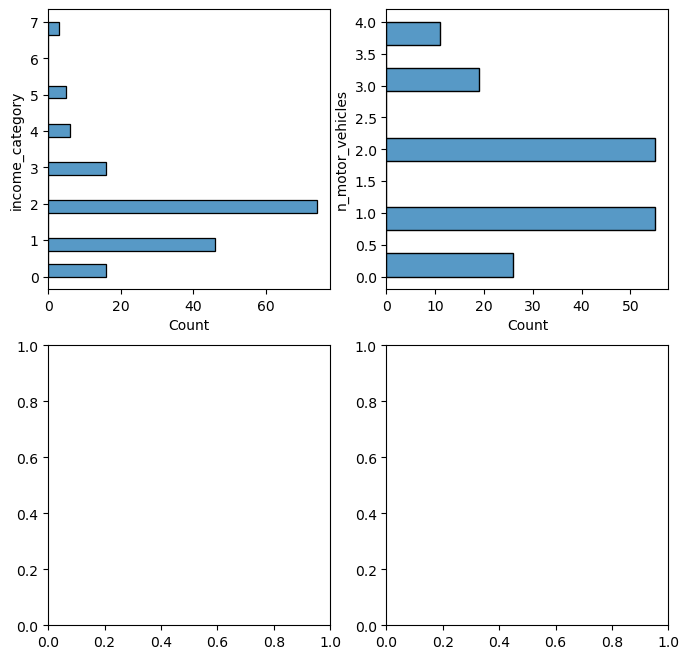

In [36]:
plot_survey_distribution(
    f_survey, ['income_category', 'n_motor_vehicles', 'primary_job_commute_mode']
)

In [ ]:
print(len(f_survey.user_id.unique()))

## GPS Data Preprocessing

In [37]:
# We only wish to focus on Denver data for now.
# denver_data = r(expanded_ct.loc[
#     (expanded_ct.start_local_dt_timezone == "America/Denver") & (expanded_ct.end_local_dt_timezone == "America/Denver"), 
#     :])

denver_data = expanded_ct.copy()

In [38]:
denver_data['start_fmt_time'] = pd.to_datetime(
    denver_data['start_fmt_time'], utc=True
).dt.tz_convert('America/Denver')

In [39]:
print(denver_data.start_fmt_time.min(), denver_data.start_fmt_time.max())

2016-08-15 07:59:32.418000-06:00 2022-12-30 23:33:27.147785-07:00


In [40]:
# Parse the datetime to Denver time.
denver_data['start_fmt_time'] = pd.to_datetime(
    denver_data['start_fmt_time'], utc=True
).dt.tz_convert('America/Denver')

# Re-compute all the start variables.
# denver_data['start_local_dt_year'] = denver_data['start_fmt_time'].dt.year
# denver_data['start_local_dt_month'] = denver_data['start_fmt_time'].dt.month
# denver_data['start_local_dt_day'] = denver_data['start_fmt_time'].dt.day
# denver_data['start_local_dt_hour'] = denver_data['start_fmt_time'].dt.hour
# denver_data['start_local_dt_weekday'] = denver_data['start_fmt_time'].dt.weekday

# ## Do the same with the end time.
denver_data['end_fmt_time'] = pd.to_datetime(
    denver_data['end_fmt_time'], utc=True
).dt.tz_convert('America/Denver')

# # Re-compute all the end variables.
# denver_data['end_local_dt_year'] = denver_data['end_fmt_time'].dt.year
# denver_data['end_local_dt_month'] = denver_data['end_fmt_time'].dt.month
# denver_data['end_local_dt_day'] = denver_data['end_fmt_time'].dt.day
# denver_data['end_local_dt_hour'] = denver_data['end_fmt_time'].dt.hour
# denver_data['end_local_dt_weekday'] = denver_data['end_fmt_time'].dt.weekday

In [41]:
# Merge the trip data with the survey data.

# inner join.
merged_data = denver_data.merge(
    f_survey, left_on='user_id', right_on='user_id'
)

In [42]:
print(len(merged_data.user_id.unique()))

166


In [43]:
# Let's start choosing features for modeling.

# base_time_features = ['fmt_time', 'local_dt_year', 'local_dt_month', 'local_dt_day', 'local_dt_hour', 'local_dt_weekday']
# time_features = ['start_' + x for x in base_time_features] + ['end_' + x for x in base_time_features]

# demographic_features = ['available_modes',
#     'birth_year', 'income_category', 'n_motor_vehicles', 'n_residence_members', 'n_residents_u18', 'gender', 
#     'is_student', 'n_residents_with_license']

# sensed_features = ['duration', 'distance_miles', 'cleaned_trip', 'start_loc', 'end_loc', 'section_modes', 'section_distances']

# modeling_data = merged_data[['user_id', '_id', 'original_user_id', 'cleaned_trip', 'Replaced_mode', 'Mode_confirm'] + time_features + demographic_features + sensed_features].copy()
modeling_data = merged_data.copy()

# Rename columns in-place.
modeling_data.rename(columns={
    'start_local_dt_year': 'start:year', 'start_local_dt_month': 'start:month', 'start_local_dt_day': 'start:day', 'start_local_dt_hour': 'start:hour',
    'end_local_dt_year': 'end:year', 'end_local_dt_month': 'end:month', 'end_local_dt_day': 'end:day', 'end_local_dt_hour': 'end:hour'
    }, inplace=True)

In [44]:
def is_overnight_trip(start_date, end_date):
    return int((end_date - start_date).days > 0)

# overnight trips may be more likely taken by car.
modeling_data['is_overnight_trip'] = modeling_data.apply(
    lambda x: is_overnight_trip(x.start_fmt_time, x.end_fmt_time), axis=1
)

# Number of working individuals in the household = number of individuals in the house - number of children.
modeling_data['n_working_residents'] = (modeling_data['n_residence_members'] - modeling_data['n_residents_u18']).astype(int)

# Convert the total duration of the trip into minutes.
modeling_data[['duration']] = modeling_data[['duration']]/60

# Extract start and end latitudes and longitudes.
modeling_data['start_lat'] = modeling_data['start_loc'].apply(lambda x: x['coordinates'][1])
modeling_data['start_lng'] = modeling_data['start_loc'].apply(lambda x: x['coordinates'][0])

modeling_data['end_lat'] = modeling_data['end_loc'].apply(lambda x: x['coordinates'][1])
modeling_data['end_lng'] = modeling_data['end_loc'].apply(lambda x: x['coordinates'][0])

In [45]:
# from calendar import monthrange

# # Find day of month: use monthrange with (mm, yyyy) args and find how many days that month had (leap years are supported).
# def get_num_days_in_month(yyyy, mm):
#     return monthrange(yyyy, mm)[1]

# def is_overnight_trip(start_date, end_date):
#     return int((end_date - start_date).days > 0)

# # get the number of days for the start and end times.
# modeling_data['start:n_days_in_month'] = modeling_data.apply(lambda x: get_num_days_in_month(x['start:year'], x['start:month']), axis=1)
# modeling_data['end:n_days_in_month'] = modeling_data.apply(lambda x: get_num_days_in_month(x['end:year'], x['end:month']), axis=1)

# # age = current year - year of birth
# modeling_data['age'] = 2023 - modeling_data['birth_year']

# # overnight trips may be more likely taken by car.
# modeling_data['is_overnight_trip'] = modeling_data.apply(lambda x: is_overnight_trip(x.start_fmt_time, x.end_fmt_time), axis=1)

# # Number of working individuals in the household = number of individuals in the house - number of children.
# modeling_data['n_working_residents'] = (modeling_data['n_residence_members'] - modeling_data['n_residents_u18']).astype(int)

# # Create a binary indicator.
# modeling_data['is_male'] = modeling_data.gender.apply(lambda x: 1 if x=="Male" else 0)

# # Bin the number of vehicles owned.
# # Drop the observations with (Prefer not to say)
# modeling_data = modeling_data.loc[~modeling_data['n_motor_vehicles'].isin(['Prefer not to say / Prefiero no decir.']), :]
# modeling_data.loc[modeling_data['n_motor_vehicles'].isin(['4+']), 'n_motor_vehicles'] = 4
# modeling_data['n_motor_vehicles'] = modeling_data['n_motor_vehicles'].astype(int)

# # Convert the total duration of the trip into minutes.
# modeling_data[['duration']] = modeling_data[['duration']]/60

# # Extract start and end latitudes and longitudes.
# modeling_data['start_lat'] = modeling_data['start_loc'].apply(lambda x: x['coordinates'][1])
# modeling_data['start_lng'] = modeling_data['start_loc'].apply(lambda x: x['coordinates'][0])

# modeling_data['end_lat'] = modeling_data['end_loc'].apply(lambda x: x['coordinates'][1])
# modeling_data['end_lng'] = modeling_data['end_loc'].apply(lambda x: x['coordinates'][0])

In [46]:
# # Time-related feature engineeering:
# '''
# HOD: hour of day
# DOM: day of month
# MOY: month of year
# '''

# def get_HOD(hour, how='sin'):
#     if how == 'sin':
#         return np.sin(2 * np.pi * (hour/24))
#     return np.cos(2 * np.pi * (hour/24))

# def get_DOM(day, n_days, how='sin'):
#     if how == 'sin':
#         return np.sin(2 * np.pi * (day/n_days))
#     return np.cos(2 * np.pi * (day/n_days))

# def get_MOY(month, how='sin'):
#     if how == 'sin':
#         return np.sin(2 * np.pi * (month/12))
#     return np.cos(2 * np.pi * (month/12))

# # Start - sin
# modeling_data['start:sin_HOD'] = modeling_data.apply(lambda x: get_HOD(x['start:hour']), axis=1)
# modeling_data['start:sin_DOM'] = modeling_data.apply(lambda x: get_DOM(x['start:day'], x['start:n_days_in_month']), axis=1)
# modeling_data['start:sin_MOY'] = modeling_data.apply(lambda x: get_MOY(x['start:year']), axis=1)

# # Start - cos
# modeling_data['start:cos_HOD'] = modeling_data.apply(lambda x: get_HOD(x['start:hour'], how='cos'), axis=1)
# modeling_data['start:cos_DOM'] = modeling_data.apply(lambda x: get_DOM(x['start:day'], x['start:n_days_in_month'], how='cos'), axis=1)
# modeling_data['start:cos_MOY'] = modeling_data.apply(lambda x: get_MOY(x['start:year'], how='cos'), axis=1)

# # End - sin
# modeling_data['end:sin_HOD'] = modeling_data.apply(lambda x: get_HOD(x['end:hour']), axis=1)
# modeling_data['end:sin_DOM'] = modeling_data.apply(lambda x: get_DOM(x['end:day'], x['end:n_days_in_month']), axis=1)
# modeling_data['end:sin_MOY'] = modeling_data.apply(lambda x: get_MOY(x['end:year']), axis=1)

# # End - cos
# modeling_data['end:cos_HOD'] = modeling_data.apply(lambda x: get_HOD(x['end:hour'], how='cos'), axis=1)
# modeling_data['end:cos_DOM'] = modeling_data.apply(lambda x: get_DOM(x['end:day'], x['end:n_days_in_month'], how='cos'), axis=1)
# modeling_data['end:cos_MOY'] = modeling_data.apply(lambda x: get_MOY(x['end:year'], how='cos'), axis=1)

In [47]:
modeling_data.head()

,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,primary_job_commute_mode_Hybrid,primary_job_commute_mode_Public transport,primary_job_commute_mode_Unknown,primary_job_commute_mode_WFH,is_overnight_trip,n_working_residents,start_lat,start_lng,end_lat,end_lng
0,DwellSegmentationDistFilter,1.629238e+09,2021-08-17 16:02:26.493017-06:00,"{'type': 'Point', 'coordinates': [-71.08788681...",611c350df3bfdd5663c34e52,1.629237e+09,2021-08-17 15:51:32.998732-06:00,"{'type': 'Point', 'coordinates': [-71.11831245...",10.891571,2700.231495,...,0.0,0.0,1.0,0.0,0,3,42.351336,-71.118312,42.347875,-71.087887
1,DwellSegmentationDistFilter,1.645386e+09,2022-02-20 12:32:43.451677-07:00,"{'type': 'Point', 'coordinates': [-111.9450490...",6212ce379106a670c421b888,1.645383e+09,2022-02-20 11:58:02.051102-07:00,"{'type': 'Point', 'coordinates': [-111.9167906...",34.690010,18093.352854,...,0.0,0.0,1.0,0.0,0,3,33.595163,-111.916791,33.461827,-111.945049
2,DwellSegmentationDistFilter,1.645391e+09,2022-02-20 14:07:17.998778-07:00,"{'type': 'Point', 'coordinates': [-111.9440840...",6212ce459106a670c421b88c,1.645388e+09,2022-02-20 13:20:30.462982-07:00,"{'type': 'Point', 'coordinates': [-111.9437005...",46.792263,984.681194,...,0.0,0.0,1.0,0.0,0,3,33.461366,-111.943701,33.460592,-111.944084
3,DwellSegmentationDistFilter,1.645397e+09,2022-02-20 15:35:51.018136-07:00,"{'type': 'Point', 'coordinates': [-111.9448744...",6212ce459106a670c421b88e,1.645397e+09,2022-02-20 15:35:16.506669-07:00,"{'type': 'Point', 'coordinates': [-111.9440840...",0.575191,183.932256,...,0.0,0.0,1.0,0.0,0,3,33.460592,-111.944084,33.462015,-111.944874
4,DwellSegmentationDistFilter,1.645405e+09,2022-02-20 17:52:13.000176-07:00,"{'type': 'Point', 'coordinates': [-110.8175686...",6214032d39cfe183d0343a07,1.645397e+09,2022-02-20 15:43:38.468902-07:00,"{'type': 'Point', 'coordinates': [-111.9448744...",128.575521,192258.374492,...,0.0,0.0,1.0,0.0,0,3,33.462015,-111.944874,32.276548,-110.817569


Now, for every trip, we have the corresponding section mode that covered the longest distance for the trip.

Using this as well as the `available_modes` column:

```language=python

    # unique available modes:
    {'Bicycle',
    'Do not have vehicle ',
    'Get a ride from a friend or family member',
    'None',
    'Public transportation (bus, subway, light rail, etc.)',
    'Rental car (including Zipcar/ Car2Go)',
    'Shared bicycle or scooter',
    'Skateboard',
    'Taxi (regular taxi, Uber, Lyft, etc)',
    'Walk/roll'}

    # unique section modes:
    {'bicycling', 'bus', 'car', 'no_sensed', 'train', 'walking'}

    
```

What mapping can we establish here? 

In [48]:
def remove_air_or_hsr(df):

    df['mark'] = 0

    for ix, row in df.iterrows():
        sections = row['section_modes']
        if 'air_or_hsr' in sections:
            df.loc[ix, 'mark'] = 1
    
    df = r(df.loc[df.mark == 0, :])
    df.drop(columns=['mark'], inplace=True)

    return df

In [49]:
modeling_data = remove_air_or_hsr(modeling_data)

In [50]:
importlib.reload(scaffolding)

<module 'scaffolding' from '/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py'>

In [51]:
results = list()

In [52]:
modeling_data = r(modeling_data.loc[:,~modeling_data.columns.duplicated()].copy())
subset = modeling_data[['original_user_id', 'cleaned_trip']]

In [53]:
num_splits = 10
samples_per_split = modeling_data.shape[0]//num_splits

In [54]:
from time import perf_counter

for split_ix in range(num_splits):
    low = samples_per_split * split_ix
    high = samples_per_split * (split_ix + 1) - 1
    split = subset.loc[low:high, :]
    
    print(f"Split {split_ix} size: {split.shape[0]}")
    
    now = perf_counter()
    result = scaffolding.get_section_durations(split)
    end = perf_counter() - now

    print(f"Took {end/60} minutes to complete")
    results.append(result)

Split 0 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling back to confirmed trips...
Falling

/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 20.352822523033332 minutes to complete
Split 2 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 19.824597845733333 minutes to complete
Split 3 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 20.249677114833336 minutes to complete
Split 4 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 18.196551645316656 minutes to complete
Split 5 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 14.953972044866669 minutes to complete
Split 6 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 13.908668193450012 minutes to complete
Split 7 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 15.91554533118333 minutes to complete
Split 8 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 14.596019812649986 minutes to complete
Split 9 size: 8069
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


Took 12.495607870950002 minutes to complete


/Users/rkulhall/em-public-dashboard/rm_src/../viz_scripts/scaffolding.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_trips['section_durations'] = confirmed_trips.parallel_apply(


In [55]:
print(len(results))

10


In [56]:
cat = pd.concat(results, axis=0)

In [57]:
print(modeling_data.shape[0], cat.shape[0])

80691 80690


In [60]:
modeling_data = modeling_data.loc[:cat.shape[0]-1, :]
print(modeling_data.shape[0])

80690


In [61]:
(modeling_data.original_user_id == cat.original_user_id).all()

True

In [62]:
display(cat.head())

,original_user_id,cleaned_trip,section_durations
0,8a0473ca-e53d-4720-a99c-0696cc1fb407,611c350ef3bfdd5663c34e5b,"[393.00192403793335, 258.49230194091797]"
1,8a0473ca-e53d-4720-a99c-0696cc1fb407,6212ce4c9106a670c421b89b,[2081.4005744457245]
2,8a0473ca-e53d-4720-a99c-0696cc1fb407,6212ce4e9106a670c421b903,[2807.5357959270477]
3,8a0473ca-e53d-4720-a99c-0696cc1fb407,6212ce4f9106a670c421b965,[34.51146650314331]
4,8a0473ca-e53d-4720-a99c-0696cc1fb407,6214033c39cfe183d0343a2f,[7714.531273841858]


In [64]:
modeling_data = pd.concat([modeling_data, cat[['section_durations']]], axis=1)

In [66]:
modeling_data.to_csv('../data/final_modeling_data_02142024.csv', index=False)